In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plot_track import plot_track
from cartesian_to_curvilinear_for_one import pose_to_curvi
import yaml
from matplotlib.widgets import Button


In [22]:

with open('all_trajectories.yaml', 'r') as f:
    data = yaml.load(f, Loader=yaml.FullLoader)
    

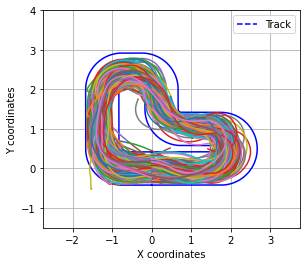

In [23]:
%matplotlib inline

data_reset = data
with open("la_track.yaml", "r") as file:
    track_shape_data = yaml.safe_load(file)

fig, ax = plt.subplots()
plot_track(fig, ax, track_shape_data)

for traj in data:
    plt.plot(data[traj]['x'], data[traj]['y'])


In [24]:
%matplotlib notebook
%matplotlib notebook

data = data_reset

filtered_data = {key: value for key, value in data.items() if 's' in value and len(value['s']) > 1000}

def update_trajectory(label):
    ax.clear()
    plot_track(fig, ax, track_shape_data)
    if label in filtered_data:
        ax.plot(filtered_data[label]['x'], filtered_data[label]['y'], label=label)
    ax.legend()
    plt.draw()

class Index:
    def __init__(self, traj_labels):
        self.idx = 0
        self.traj_labels = traj_labels

    def next(self, event):
        self.idx = (self.idx + 1) % len(self.traj_labels)
        update_trajectory(self.traj_labels[self.idx])

    def prev(self, event):
        self.idx = (self.idx - 1) % len(self.traj_labels)
        update_trajectory(self.traj_labels[self.idx])


fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)

plot_track(fig, ax, track_shape_data)

initial_traj = list(filtered_data.keys())[0]
ax.plot(filtered_data[initial_traj]['x'], filtered_data[initial_traj]['y'], label=initial_traj)
ax.legend()

axprev = plt.axes([0.7, 0.05, 0.1, 0.075]) 
axnext = plt.axes([0.81, 0.05, 0.1, 0.075]) 

traj_labels = list(filtered_data.keys())
callback = Index(traj_labels)
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)

# Show the plot
plt.show()

<IPython.core.display.Javascript object>

In [25]:
import yaml
import numpy as np

data = data_reset

# create added data in the same format as the filtered data and same type but all empty inside added_data

added_data = {key: {key: [] for key in value} for key, value in filtered_data.items()}

filtered_data = {key: value for key, value in data.items() if 's' in value and len(value['s']) > 1000}


# Function to convert NumPy types to native Python types
def numpy_to_native(value):
    """
    Convert NumPy types to Python native types (float, int, list, etc.)
    to avoid serialization issues in YAML.
    """
    if isinstance(value, np.ndarray):
        return value.tolist()  # Convert NumPy arrays to Python lists
    elif isinstance(value, np.generic):
        return value.item()  # Convert NumPy scalars to Python scalars
    return value

def add_noise(x, y, heading_angle, pos_std=0.1, theta_std=0.05):
    noisy_x = x + np.random.normal(0, pos_std)
    noisy_y = y + np.random.normal(0, pos_std)
    noisy_heading = heading_angle + np.random.normal(0, theta_std)
    return float(noisy_x), float(noisy_y), float(noisy_heading)

def compute_target_point(x, y, vehicle_theta, trajectory, deltaS, s):

    try:
        x_traj = np.array(trajectory['x'])
        y_traj = np.array(trajectory['y'])
        s_traj = np.array(trajectory['s'])
    except KeyError:
        x_traj = np.array(trajectory['xCoords'])
        y_traj = np.array(trajectory['yCoords'])
        s_traj = np.array(trajectory['arcLength'])

    distances = np.sqrt((x_traj - x)**2 + (y_traj - y)**2)

    direction_vectors = np.array([x_traj- x, y_traj - y]).T
    
    forward_indices = [
        i for i in range(len(direction_vectors))
        if s_traj[i] > s + deltaS
    ]

    if not forward_indices:
        target_idx = np.argmin(distances)
        return x_traj[target_idx], y_traj[target_idx]

    if not forward_indices:
        target_idx = forward_indices[-1]
        return x_traj[target_idx], y_traj[target_idx]

    target_idx = forward_indices[0]
    return x_traj[target_idx], y_traj[target_idx]


def pure_pursuit_controller(x, y, heading_angle, trajectory, deltaS, s):

    target_x, target_y = compute_target_point(x, y, heading_angle, trajectory, deltaS, s)

    dx = target_x - x
    dy = target_y - y
    target_angle = np.arctan2(dy, dx)

    heading_error = target_angle - heading_angle
   
    if heading_error > np.pi:
        heading_error -= 2 * np.pi
    else:
        if heading_error < -np.pi:
            heading_error += 2 * np.pi
    
    wheelbase = 0.098

    lookahead_distance = np.sqrt(dx**2 + dy**2)
    
    steering_angle = np.arctan2(2.0 * wheelbase * np.sin(heading_error), lookahead_distance)
    
    return steering_angle, target_x, target_y

Kdd = 0.30
new_trajectories = []

with open("la_track.yaml", "r") as file:
    track_shape_data = yaml.safe_load(file)
 
track_shape_data['track']['xCoords'] = np.array(track_shape_data['track']['xCoords']) - track_shape_data['track']['x_init']
track_shape_data['track']['yCoords'] = np.array(track_shape_data['track']['yCoords']) - track_shape_data['track']['y_init']

for traj_key, trajectory in filtered_data.items():
    noisy_trajectory = []
    
    for i in range(1, len(trajectory['s']), 5):
        if i >= len(trajectory['x']):
            break

        x = trajectory['x'][i]
        y = trajectory['y'][i]
        heading_angle = trajectory['heading_angle'][i]
        v = np.sqrt(trajectory['vx'][i] ** 2 + trajectory['vy'][i] ** 2)
        
        # Add Gaussian noise to x, y, and heading angle
        noisy_x, noisy_y, noisy_heading_angle = add_noise(x, y, heading_angle, pos_std=0.5, theta_std=0.5)
        
        # Transform the noisy (x, y, heading_angle) to curvilinear coordinates (s, e, dtheta)
        noisy_s, noisy_e, noisy_dtheta = pose_to_curvi(track_shape_data, np.array([noisy_x, noisy_y, noisy_heading_angle]), bring_to_origin = False)
        
        # Calculate the steering angle using pure pursuit
        deltaS = v * Kdd    
        
        # Follow the track
        steering_angle, _ , _  = pure_pursuit_controller(noisy_x, noisy_y, noisy_heading_angle, track_shape_data['track'], deltaS, s = noisy_s)

        # Follow the trajectory
        # steering_angle, _ , _  = pure_pursuit_controller(noisy_x, noisy_y, noisy_heading_angle, trajectory, deltaS, s = noisy_s)

        steering = np.clip(steering_angle / np.deg2rad(17), -1 , 1)

        # Convert values to native Python types
        noisy_s = numpy_to_native(noisy_s)
        noisy_e = numpy_to_native(noisy_e)
        noisy_dtheta = numpy_to_native(noisy_dtheta)
        steering_angle = numpy_to_native(steering_angle)
        noisy_x = numpy_to_native(noisy_x)
        noisy_y = numpy_to_native(noisy_y)
        noisy_heading_angle = numpy_to_native(noisy_heading_angle)
        steering = numpy_to_native(steering)

        filtered_data[traj_key]['x'] = list(filtered_data[traj_key]['x'])
        filtered_data[traj_key]['y'] = list(filtered_data[traj_key]['y'])
        filtered_data[traj_key]['heading_angle'] = list(filtered_data[traj_key]['heading_angle'])

        filtered_data[traj_key]['s'].append(noisy_s)
        filtered_data[traj_key]['e'].append(noisy_e)
        filtered_data[traj_key]['dtheta'].append(noisy_dtheta)
        filtered_data[traj_key]['vx'].append(data[traj_key]['vx'][i])
        filtered_data[traj_key]['vy'].append(data[traj_key]['vy'][i])
        filtered_data[traj_key]['omega'].append(data[traj_key]['omega'][i])
        filtered_data[traj_key]['steering'].append(steering)
        filtered_data[traj_key]['throttle'].append(data[traj_key]['throttle'][i])
        filtered_data[traj_key]['x'].append(noisy_x)
        filtered_data[traj_key]['y'].append(noisy_y)
        filtered_data[traj_key]['heading_angle'].append(noisy_heading_angle)

        added_data[traj_key]['s'].append(noisy_s)
        added_data[traj_key]['e'].append(noisy_e)
        added_data[traj_key]['dtheta'].append(noisy_dtheta)
        added_data[traj_key]['vx'].append(data[traj_key]['vx'][i])
        added_data[traj_key]['vy'].append(data[traj_key]['vy'][i])
        added_data[traj_key]['omega'].append(data[traj_key]['omega'][i])
        added_data[traj_key]['steering'].append(steering)
        added_data[traj_key]['throttle'].append(data[traj_key]['throttle'][i])
        added_data[traj_key]['x'].append(noisy_x)
        added_data[traj_key]['y'].append(noisy_y)
        added_data[traj_key]['heading_angle'].append(noisy_heading_angle)

        




In [26]:


def convert_numpy_types(data):
    """
    Recursively traverses the data structure and:
    - Converts any NumPy scalars (e.g., np.float64, np.int32) to native Python types.
    - Converts any NumPy arrays to Python lists.
    """
    if isinstance(data, dict):
        for key, value in data.items():
            data[key] = convert_numpy_types(value)  
    elif isinstance(data, list):
        for i, item in enumerate(data):
            data[i] = convert_numpy_types(item)
    elif isinstance(data, np.ndarray):  
        return data.tolist()
    elif isinstance(data, np.generic): 
        return data.item()  
    else:
        return data
    
    return data  

def check_numpy_types(data):
    if isinstance(data, dict):
        for key, value in data.items():
            check_numpy_types(value)  
    elif isinstance(data, list):
        for item in data:
            check_numpy_types(item)  
    elif isinstance(data, np.ndarray):
        print(f"Found NumPy array: {data}")
    elif isinstance(data, np.generic):
        print(f"Found NumPy scalar: {data}")
    else:
        pass

convert_numpy_types(filtered_data)
check_numpy_types(filtered_data)

In [27]:
def update_trajectory(label):
    ax.clear()
    plot_track(fig, ax, track_shape_data)
    i = 0
    if label in filtered_data:
        # Plot the individual points without connecting them
        ax.scatter(added_data[label]['x'], added_data[label]['y'], label=label, color='b')
        
        # Add arrows to indicate the steering angle
        for i in range(len(added_data[label]['x'])):
            x = added_data[label]['x'][i]
            y = added_data[label]['y'][i]
            heading_angle = added_data[label]['heading_angle'][i]
            steering_angle = added_data[label]['steering'][i]

            # Determine the direction of the arrow based on heading angle and steering angle
            arrow_length = 0.3  # You can adjust this to make arrows bigger/smaller
            dx = arrow_length * np.cos(heading_angle)
            dy = arrow_length * np.sin(heading_angle)

            dx_steer = arrow_length * np.cos(heading_angle + steering_angle)
            dy_steer = arrow_length * np.sin(heading_angle + steering_angle)

            
            # Draw an arrow for the steering angle
            if i == 0:
                ax.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='r', alpha=0.6, label='Heading')
                ax.quiver(x, y, dx_steer, dy_steer, angles='xy', scale_units='xy', scale=1, color='g', alpha=0.6, label='Steering')
            else:
                ax.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='r', alpha=0.6)
                ax.quiver(x, y, dx_steer, dy_steer, angles='xy', scale_units='xy', scale=1, color='g', alpha=0.6)
                
            i += 1
        

    ax.legend()
    plt.draw()
class Index:
    def __init__(self, traj_labels):
        self.idx = 0
        self.traj_labels = traj_labels

    def next(self, event):
        self.idx = (self.idx + 1) % len(self.traj_labels)
        update_trajectory(self.traj_labels[self.idx])

    def prev(self, event):
        self.idx = (self.idx - 1) % len(self.traj_labels)
        update_trajectory(self.traj_labels[self.idx])

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.2)

track_shape_data['track']['xCoords'] = np.array(track_shape_data['track']['xCoords']) + track_shape_data['track']['x_init']
track_shape_data['track']['yCoords'] = np.array(track_shape_data['track']['yCoords']) + track_shape_data['track']['y_init']

plot_track(fig, ax, track_shape_data)

initial_traj = list(filtered_data.keys())[0]
ax.plot(added_data[initial_traj]['x'], added_data[initial_traj]['y'], label=initial_traj)
ax.legend()

axprev = plt.axes([0.7, 0.05, 0.1, 0.075]) 
axnext = plt.axes([0.81, 0.05, 0.1, 0.075]) 

traj_labels = list(added_data.keys())
callback = Index(traj_labels)
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
bprev = Button(axprev, 'Previous')
bprev.on_clicked(callback.prev)

# Show the plot
plt.show()


<IPython.core.display.Javascript object>

In [28]:
# Save the new dataset with noisy trajectories, ensuring no NumPy types are in the data
with open('noisy_trajectories.yaml', 'w') as f:
    yaml.dump(filtered_data, f, default_flow_style=False)